<a href="https://colab.research.google.com/github/LyubovKazlova/TS/blob/main/TS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [2]:
from mplfinance.original_flavor import candlestick_ohlc
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
def get_price_data(ticker='DIS'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-1-1')
    return tickerDf.iloc[:, :5]

In [31]:
# get price data (return pandas dataframe)
df_dis = get_price_data()

In [32]:
df_dis.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04 00:00:00-05:00,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05 00:00:00-05:00,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06 00:00:00-05:00,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09 00:00:00-05:00,39.900002,40.088501,39.588501,39.846001,68922000


In [6]:
def get_price_data(ticker='AMZN'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-1-1')
    return tickerDf.iloc[:, :5]

In [33]:
# get price data (return pandas dataframe)
df_am = get_price_data()

In [34]:
df_am.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04 00:00:00-05:00,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05 00:00:00-05:00,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06 00:00:00-05:00,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09 00:00:00-05:00,39.900002,40.088501,39.588501,39.846001,68922000


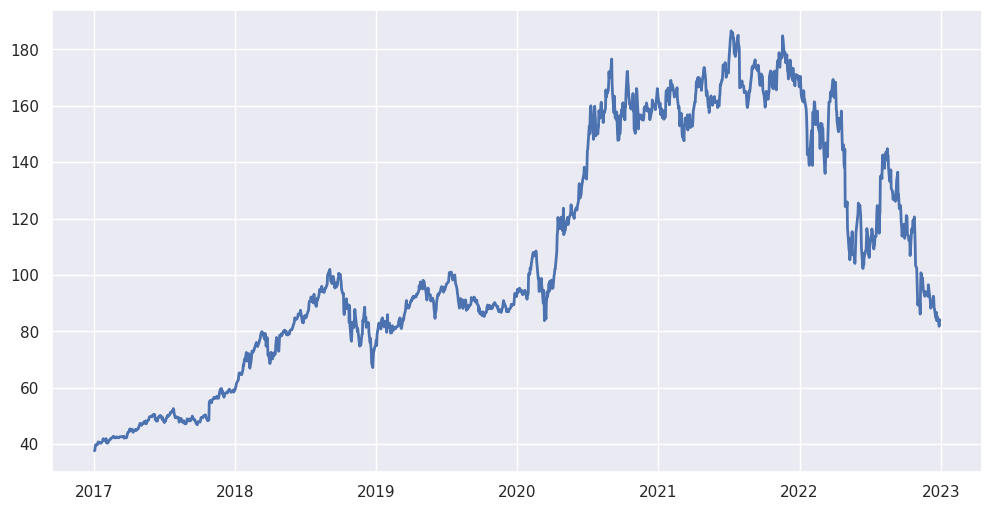

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df_dis['Close'], linewidth=2.0)
plt.show()

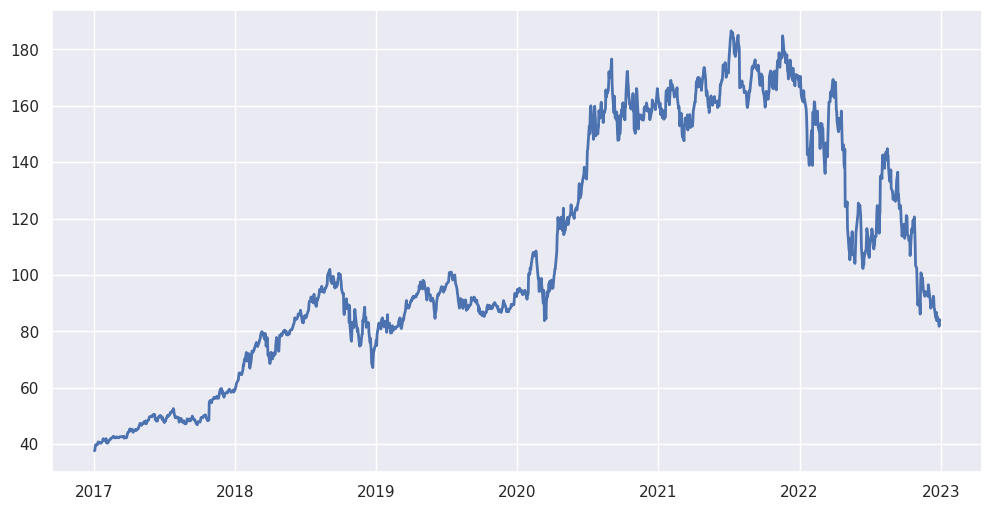

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df_am['Close'], linewidth=2.0)
plt.show()


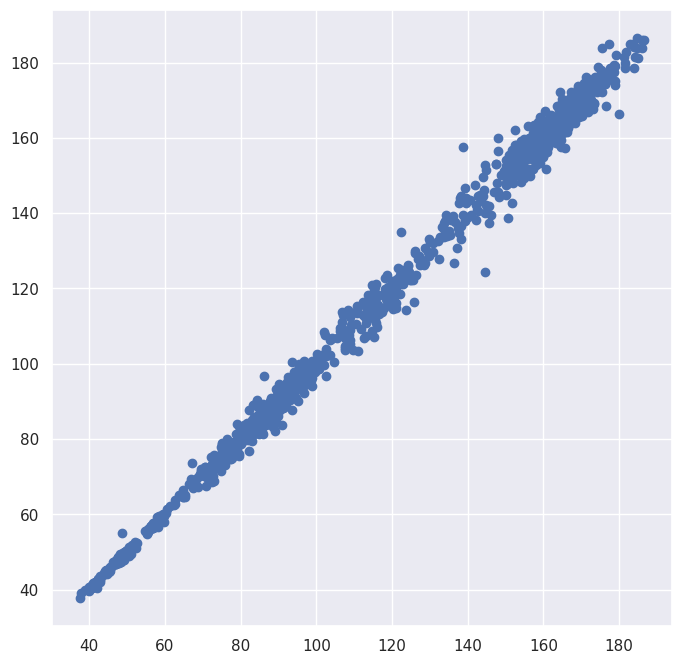

In [37]:
x = df_dis['Close'][:-1]
y = df_dis['Close'][1:]
plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.show()

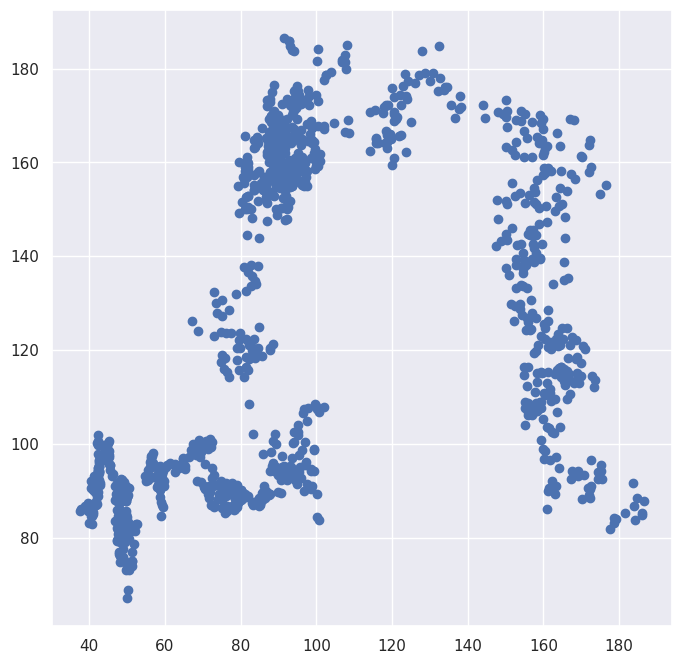

In [38]:
x = df_am['Close'][:-365]
y = df_am['Close'][365:]
plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.show()

In [39]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [56]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [57]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [59]:
series = df_dis['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.692440
p-value                           0.435012
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64


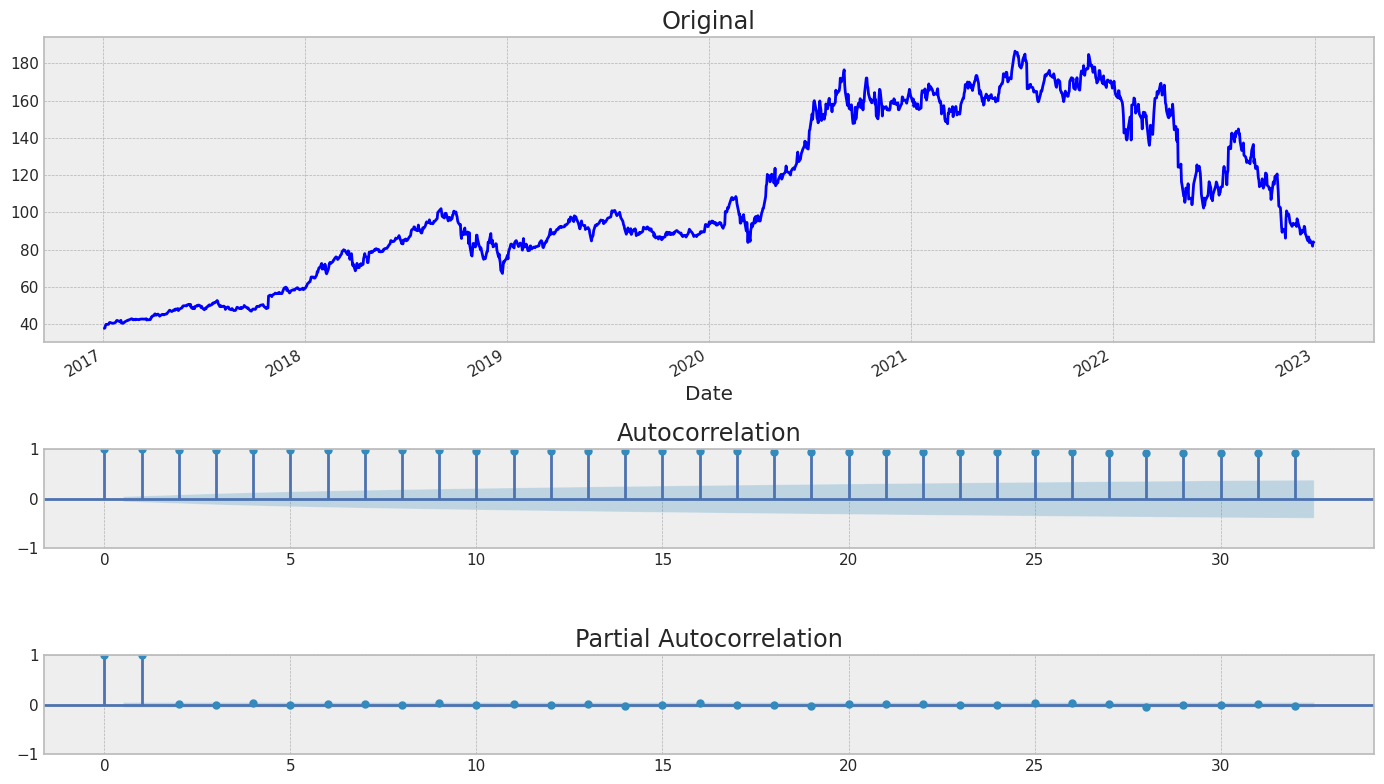

In [60]:
tsplot(series)

In [61]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -2.266559
p-value                           0.182980
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64


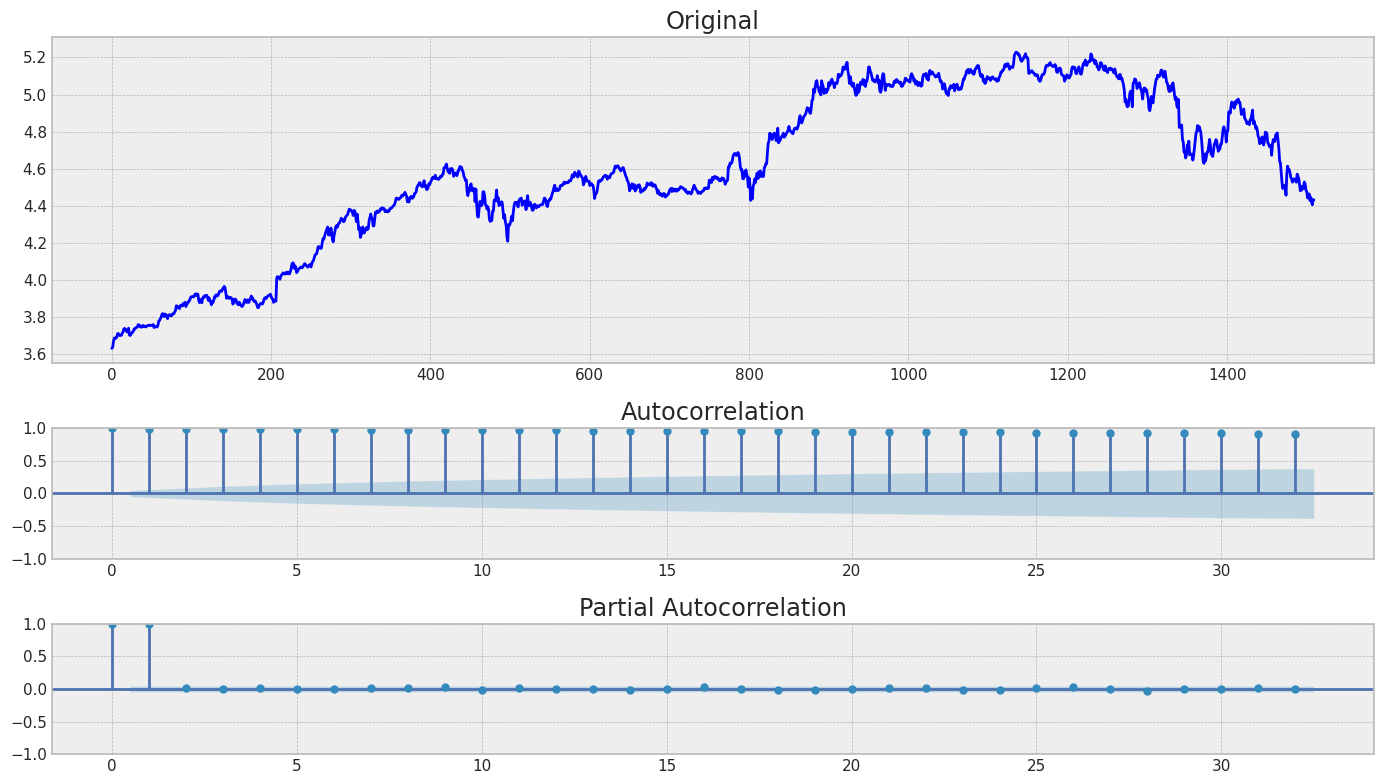

In [62]:
tsplot(series)

In [67]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.222705e+01
p-value                        1.074580e-22
#Lags Used                     2.100000e+01
Number of Observations Used    1.121000e+03
Critical Value (1%)           -3.436197e+00
Critical Value (5%)           -2.864122e+00
Critical Value (10%)          -2.568145e+00
dtype: float64


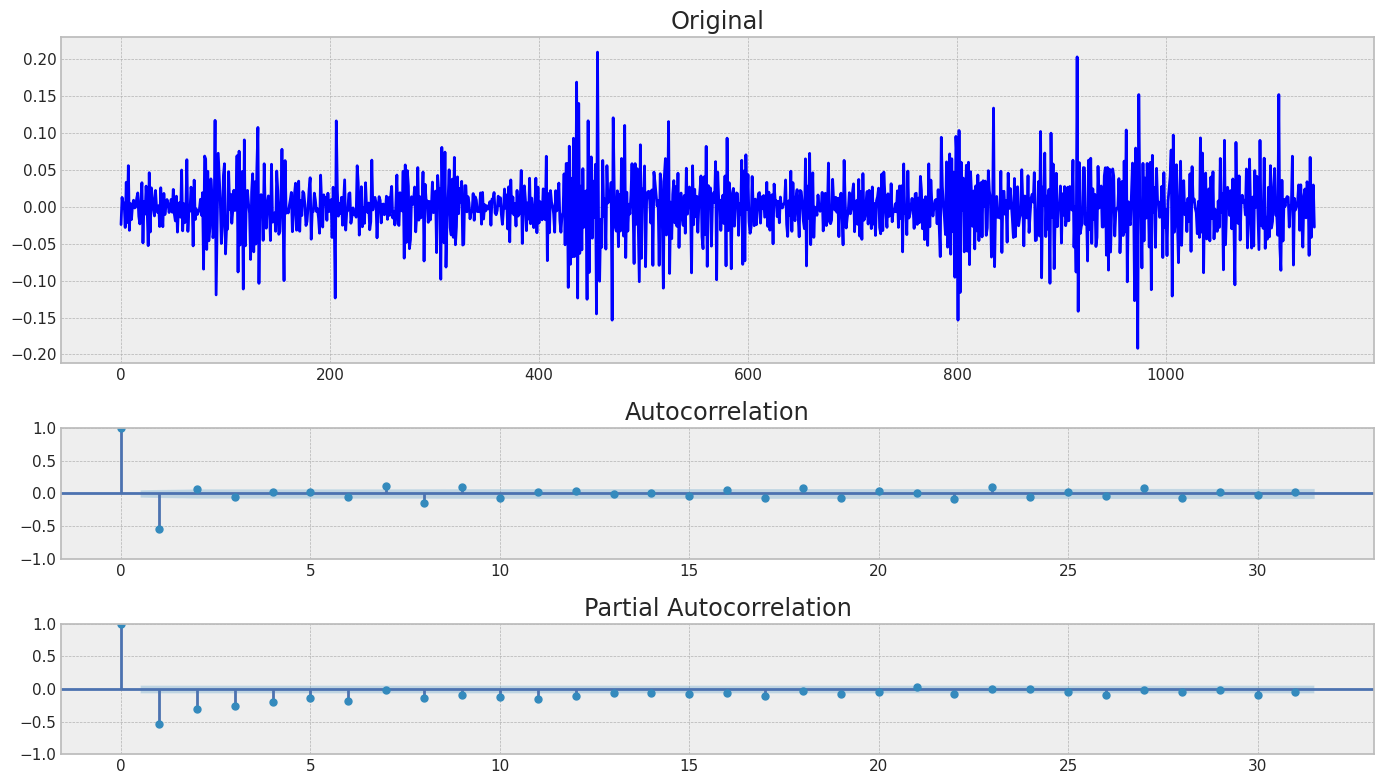

In [68]:
tsplot(series)

In [70]:
series_am = df_am['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.692440
p-value                           0.435012
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64


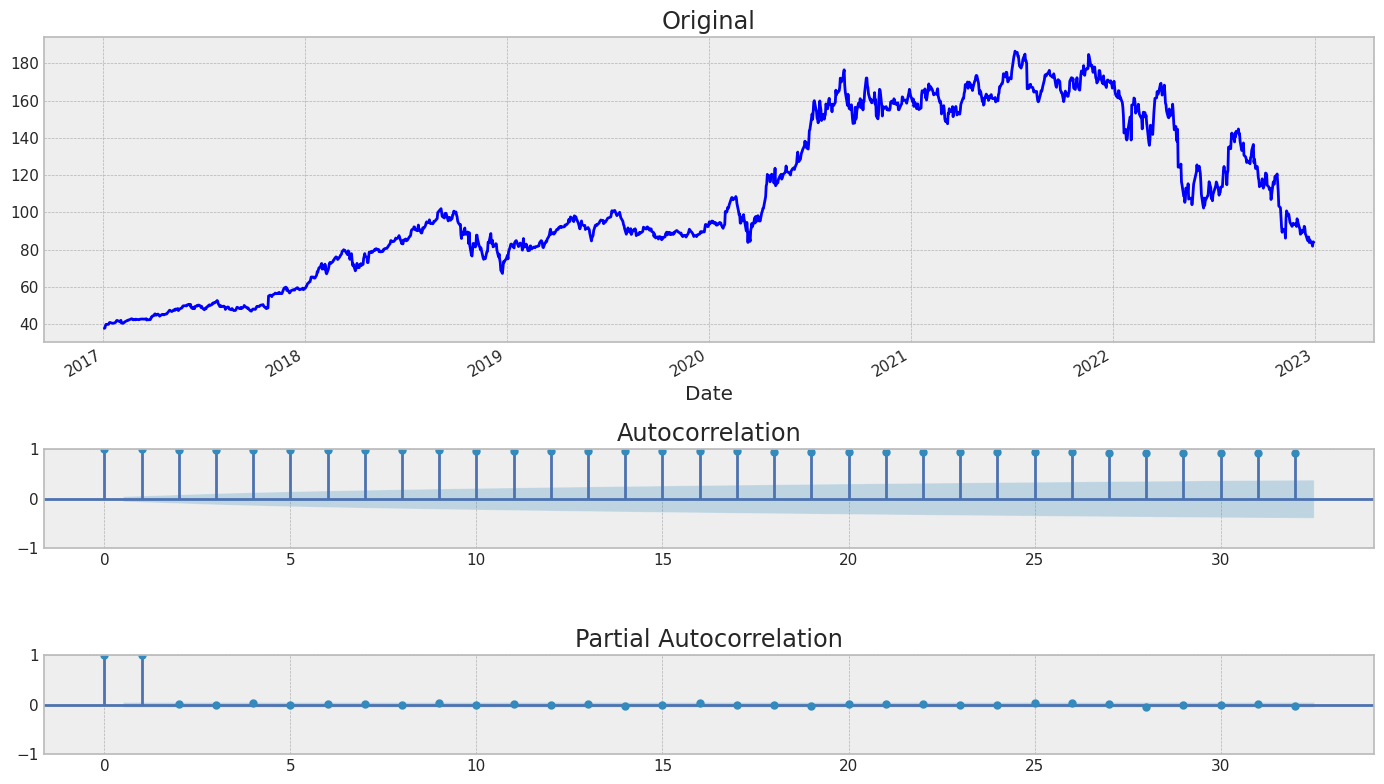

In [71]:
tsplot(series_am)

In [74]:
series_am = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -2.498875
p-value                           0.115748
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64


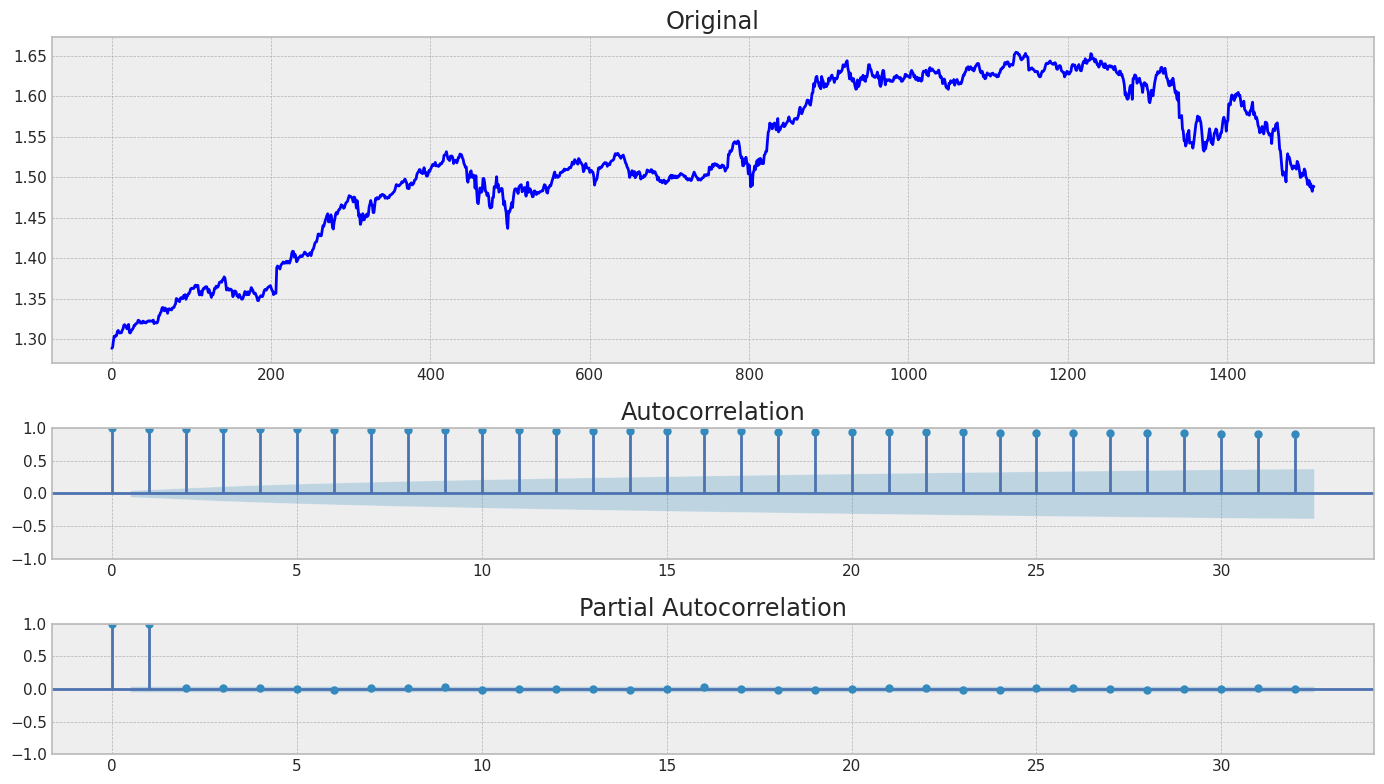

In [75]:
tsplot(series_am)

In [76]:
series_am = series_am[1:] - series_am[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.513463e+01
p-value                        7.150973e-28
#Lags Used                     7.000000e+00
Number of Observations Used    1.501000e+03
Critical Value (1%)           -3.434714e+00
Critical Value (5%)           -2.863467e+00
Critical Value (10%)          -2.567796e+00
dtype: float64


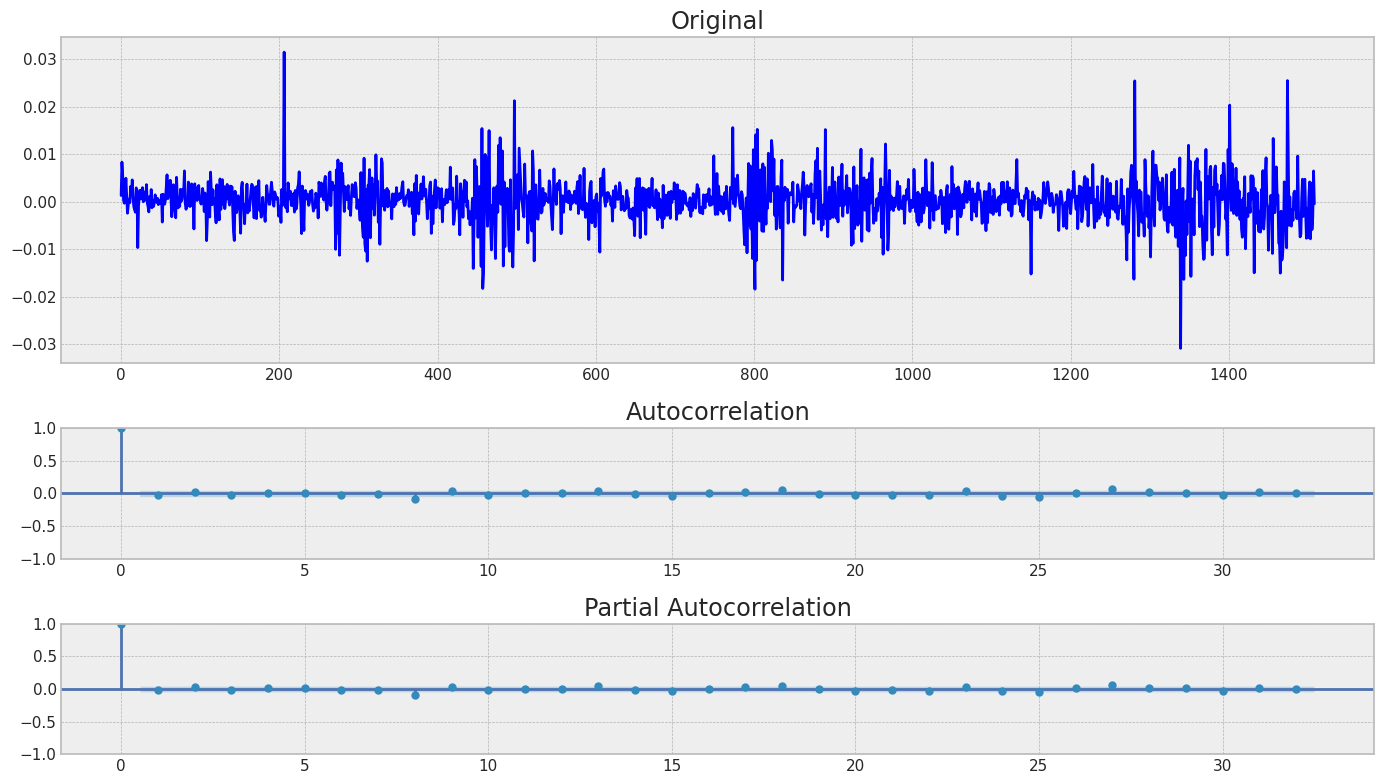

In [77]:
tsplot(series_am)

Для анализа были выбраны показатели стоимости акций на конец дня корпорации Disney и Amazon в период с 1 января 2017 до 1 января 2023гг.
Оба ряда не были стационарными, в обоих рядах не было равномерного тренда (но он прослеживался в определенные периоды), не выявлено сезонности и цикличности.
При анализе автокорреляции - зависимость только по предыдущему дню, зависимость от годового цикла отсутствует. Путем преобразований (бокс-кокс и дифференцирование) удалось добиться стационарности временного ряда.